In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle


import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


import os
import multiprocessing


os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [2]:
from src.model import SSCNetwork
from Network_Definition.forward import forward
from Network_Definition.parameters import network_parameters
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_latent_accuracy, get_signal_to_noise_ratio

from src.utils.Figure_2 import figure2_accuracy

In [3]:
network_model = {}
network_model["forward"] = forward

recording_parameters = {}
recording_parameters["regions"] = ["hidden", "output_hat", "output"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["hidden_hidden"]
recording_parameters["rate_connectivity"] = 100



input_params = {}
input_params["num_days"] = 500
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 0

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [4]:
input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

In [5]:
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0
50
100
150
200
250
300
350
400
450


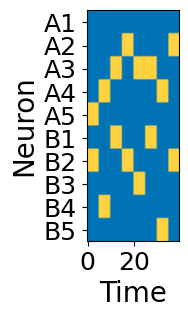

In [6]:


fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2B1.svg", dpi=300, transparent=True)



In [7]:
X_output = torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)
X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))

network.selectivity_output_episodes, network.ordered_indices_output_episodes = get_ordered_indices(X_output, X_episodes, assembly_size=2)


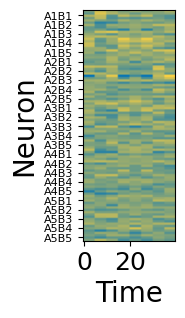

In [8]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["output_hat"], dim=0)[network.awake_indices][-input_params["day_length"]//2:, network.ordered_indices_output_episodes[:100]].reshape(-1, 100).T, cmap=blue_yellow) 


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes =  [M * (k + 0.5) for k in range(NA * NB)]
plt.yticks(positions_episodes, labels_episodes, fontsize=8)

plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2B2.svg", dpi=300, transparent=True)

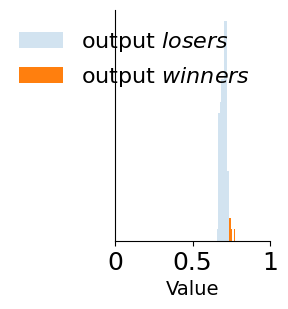

In [9]:

fig = plt.figure(figsize=(2, 3))

output= torch.stack(network.activity_recordings["output_hat"], dim=0)[network.awake_indices][-1, network.ordered_indices_output_episodes[:100]]
output_winners = torch.topk(output, 4)[0]
output_losers = torch.topk(output, 100)[0][4:]

bin_size = 0.01  # tamaño de bin fijo


data_min = min(output_losers.min(), output_winners.min())
data_max = max(output_losers.max(), output_winners.max())


bins = np.arange(data_min, data_max + bin_size, bin_size)

plt.hist(output_losers, bins=bins, alpha=0.2, label=r"output $\it{losers}$", color="C0")
plt.hist(output_winners, bins=bins, alpha=1, label=r"output $\it{winners}$", color="C1")

plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.yticks([])

plt.xlabel("Value", fontsize=14)
plt.legend(fontsize=16, frameon=False)
sns.despine()

plt.savefig("Figures/SVG/2B3.svg", dpi=300, transparent=True)

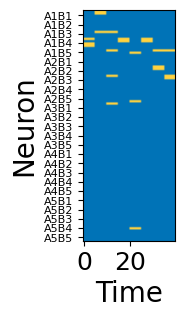

In [10]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][-input_params["day_length"]//2:, network.ordered_indices_output_episodes[:100]].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1) 


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes =  [M * (k + 0.5) for k in range(NA * NB)]
plt.yticks(positions_episodes, labels_episodes, fontsize=8)

plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2B4.svg", dpi=300, transparent=True)

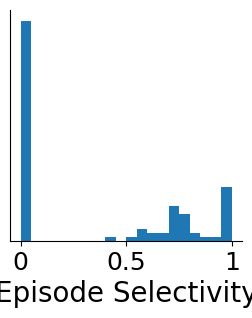

In [11]:
fig = plt.figure(figsize=(3, 3))
plt.hist(network.selectivity_output_episodes.max(axis=1)[0].flatten(), bins=20)
plt.xlabel("Episode Selectivity", fontsize=20)
plt.yticks([])
plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
sns.despine()


plt.savefig("Figures/SVG/2C1.svg", dpi=300, transparent=True)

In [12]:
acc = get_latent_accuracy(X_output, network.selectivity_output_episodes, X_episodes.flatten(end_dim=1))

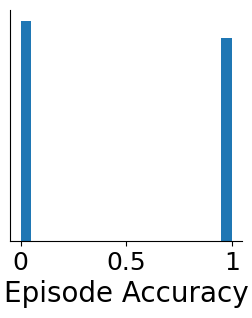

In [13]:
fig = plt.figure(figsize=(3, 3))
plt.hist(acc, bins=20)
plt.xlabel("Episode Accuracy", fontsize=20)
plt.yticks([])
plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
sns.despine()

plt.savefig("Figures/SVG/2C2.svg", dpi=300, transparent=True)

In [57]:
seed_everything(0)

input_params["num_swaps"] = 4

input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0
50
100
150
200
250
300
350
400
450


SNR = 1.5


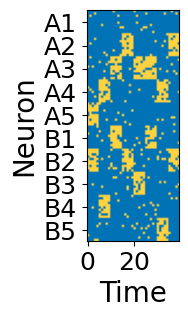

In [58]:


print("SNR = {}".format(get_signal_to_noise_ratio(input_params["num_swaps"], network.hidden_size*network.hidden_sparsity[0], network.hidden_size)))

fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2D1.svg", dpi=300, transparent=True)

In [59]:
seed_everything(0)

input_params["num_swaps"] = 10

input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0
50
100
150
200
250
300
350
400
450


SNR = 0.30000001192092896


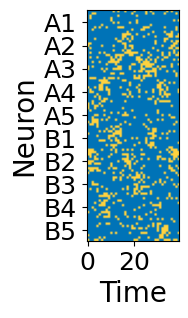

In [60]:
print("SNR = {}".format(get_signal_to_noise_ratio(input_params["num_swaps"], network.hidden_size*network.hidden_sparsity[0], network.hidden_size)))


fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2D2.svg", dpi=300, transparent=True)

In [55]:
num_cpu = 8
num_swaps_list = np.arange(0, 17, 2)
snr_list = [get_signal_to_noise_ratio(num_swaps, network.hidden_size*network.hidden_sparsity[0], network.hidden_size, ) for num_swaps in num_swaps_list]

num_seeds = 10
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [56]:

experiment_params = [(network_parameters, network_model, recording_parameters, input_params, latent_specs, num_swaps, seed) for num_swaps in num_swaps_list for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(figure2_accuracy, experiment_params)

In [24]:

def save_results(results_list, filename):


    results = {}
    results["accuracy_output"] = []
    results["selectivity_output"] = []



    for accuracy_output, selectivity_output in results_list:

        results["accuracy_output"].append(accuracy_output)
        results["selectivity_output"].append(selectivity_output)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_2_selectivity_accuracy.pickle')



In [25]:
with open('Data/{}'.format('fig_2_selectivity_accuracy.pickle'), 'rb') as handle:
    results = pickle.load(handle)

In [31]:
mean_sel = np.array(results["selectivity_output"]).reshape((9, 10, 100, 25)).max(axis=-1).mean(axis=(1,  2))
std_sel = np.array(results["selectivity_output"]).reshape((9, 10, 100, 25)).max(axis=-1).std(axis=(1,  2))
mean_acc = np.array(results["accuracy_output"]).reshape((9, 10, 25)).mean(axis=(1,  2))
std_acc = np.array(results["accuracy_output"]).reshape((9, 10, 25)).std(axis=(1,  2))

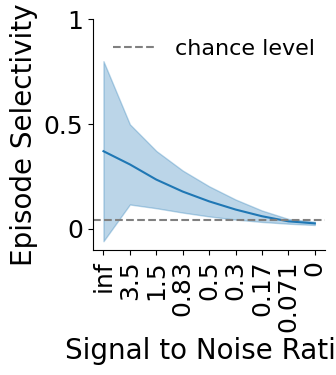

In [53]:
snr_labels = [f"{x:.2g}" for x in snr_list]

fig = plt.figure(figsize=(3,3))

x = np.arange(len(mean_sel))  # eje x
plt.plot(snr_labels, mean_sel, color="C0")
plt.fill_between(x, mean_sel - std_sel, mean_sel + std_sel, alpha=0.3, color="C0")



plt.xlabel("Signal to Noise Ratio", fontsize=20)
plt.ylabel("Episode Selectivity", fontsize=20)
plt.yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.xticks(snr_labels, fontsize=18, rotation=90)
sns.despine()

plt.axhline(1/25, linestyle='dashed', color='gray', label='chance level')

plt.legend(fontsize=16, frameon=False)

plt.savefig("Figures/SVG/2F1.svg", dpi=300, transparent=True)

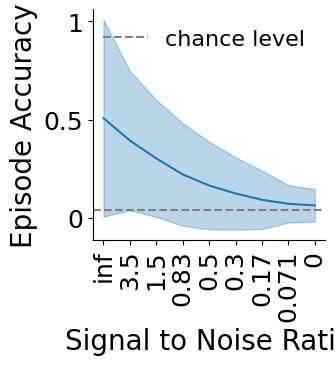

In [54]:
fig = plt.figure(figsize=(3,3))


plt.plot(snr_labels, mean_acc, color="C0")
plt.fill_between(x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, color="C0")

plt.xlabel("Signal to Noise Ratio", fontsize=20)
plt.ylabel("Episode Accuracy", fontsize=20)
plt.yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.xticks(snr_labels, fontsize=18, rotation=90)
sns.despine()

plt.axhline(1/25, linestyle='dashed', color='gray', label='chance level')

plt.legend(fontsize=16, frameon=False)

plt.savefig("Figures/SVG/2F2.svg", dpi=300, transparent=True)